# Download kaggle management

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Make directory kaggle

In [ ]:
!mkdir ~/.kaggle

Copy kaggle.json to folder kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

Change mod for owner

owner,group,others

4: read

2: write

1: execute

600 -> owner has mod read and write

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

Download data (Ravdess)

In [ ]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
 96% 411M/429M [00:05<00:00, 64.9MB/s]
100% 429M/429M [00:05<00:00, 81.3MB/s]


Unzip data

In [ ]:
!unzip /content/ravdess-emotional-speech-audio.zip

Archive:  /content/ravdess-emotional-speech-audio.zip
  inflating: Actor_01/03-01-01-01-01-01-01.wav  
  inflating: Actor_01/03-01-01-01-01-02-01.wav  
  inflating: Actor_01/03-01-01-01-02-01-01.wav  
  inflating: Actor_01/03-01-01-01-02-02-01.wav  
  inflating: Actor_01/03-01-02-01-01-01-01.wav  
  inflating: Actor_01/03-01-02-01-01-02-01.wav  
  inflating: Actor_01/03-01-02-01-02-01-01.wav  
  inflating: Actor_01/03-01-02-01-02-02-01.wav  
  inflating: Actor_01/03-01-02-02-01-01-01.wav  
  inflating: Actor_01/03-01-02-02-01-02-01.wav  
  inflating: Actor_01/03-01-02-02-02-01-01.wav  
  inflating: Actor_01/03-01-02-02-02-02-01.wav  
  inflating: Actor_01/03-01-03-01-01-01-01.wav  
  inflating: Actor_01/03-01-03-01-01-02-01.wav  
  inflating: Actor_01/03-01-03-01-02-01-01.wav  
  inflating: Actor_01/03-01-03-01-02-02-01.wav  
  inflating: Actor_01/03-01-03-02-01-01-01.wav  
  inflating: Actor_01/03-01-03-02-01-02-01.wav  
  inflating: Actor_01/03-01-03-02-02-01-01.wav  
  inflating: Ac

Move all folders into folder ravdess

In [ ]:
!mkdir ravdess

In [ ]:
!mv Actor_* ravdess
!mv audio_speech_actors_01-24/ ravdess

In [ ]:
!pip install google-generativeai faiss-cpu numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 72.2 MB/s eta 0:00:00


# Importing libraries and initializing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])


# Preprocessing data and extract features

In [ ]:
audio_files = glob('/content/ravdess/*/*.wav')
ipd.Audio(audio_files[0])

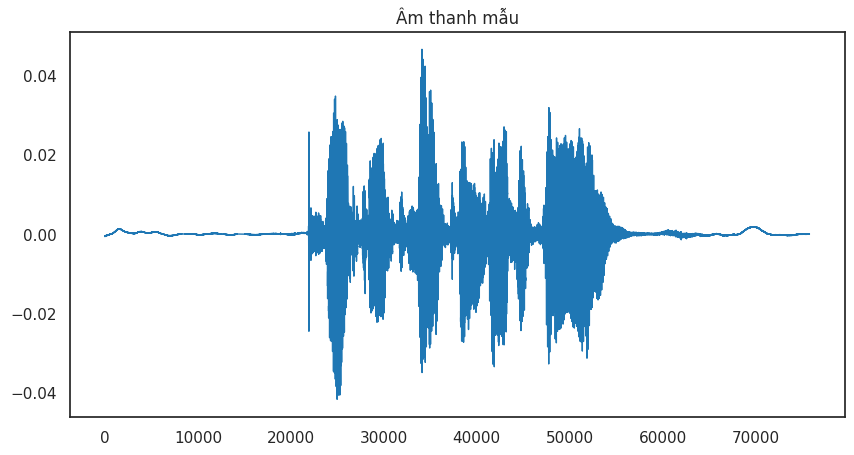

In [ ]:
y, sr = librosa.load(audio_files[0])
# y là thông tin của âm thanh, sr có thể được hiểu như "độ phân giải" của âm thanh

pd.Series(y).plot(figsize = (10, 5), lw = 1, title = 'Âm thanh mẫu', color = color_pal[0])
plt.show()

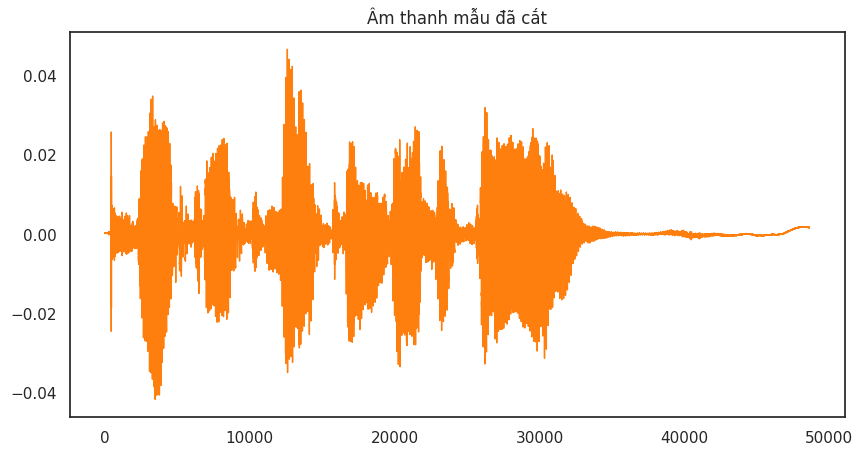

In [ ]:
y_trimmed, _ = librosa.effects.trim(y, top_db = 20) # Cắt bỏ phần thừa từ âm thanh

pd.Series(y_trimmed).plot(figsize = (10, 5), lw = 1, title = 'Âm thanh mẫu đã cắt', color = color_pal[1])
plt.show()

(13, 208)


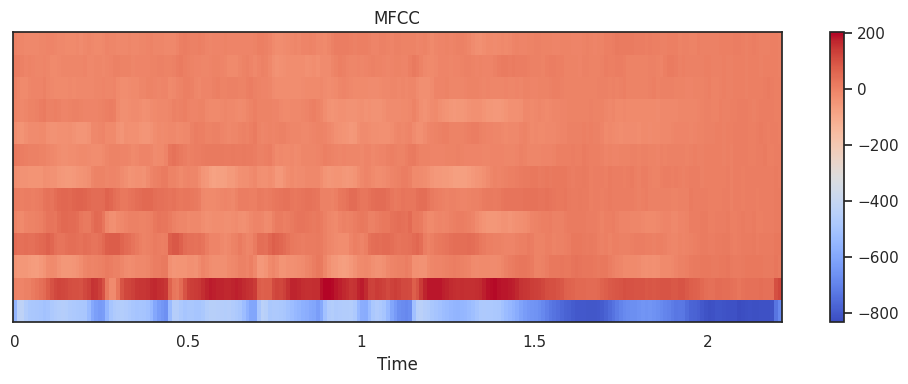

In [ ]:
y, sr = librosa.load(audio_files[0], sr=None)
y_trimmed, _ = librosa.effects.trim(y, top_db = 20)
mfccs = librosa.feature.mfcc(y=y_trimmed, sr=sr, n_mfcc=13)

print(mfccs.shape)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis="time", sr=sr)
plt.colorbar()
plt.title("MFCC")
plt.tight_layout()
plt.show()

In [ ]:
def extract_features(file_path, n_mfcc = 13): # Trả về mean và std của mfcc của âm thanh
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)

    feature_vector = np.hstack([mfcc_mean, mfcc_std])
    return feature_vector

In [ ]:
X = np.array([extract_features(f) for f in audio_files])
X[0]

array([-6.8258313e+02,  8.0966087e+01, -1.9440162e+00,  1.7106361e+01,
        4.7443981e+00,  1.6504490e+01, -8.1581020e+00,  4.9049896e-01,
       -7.9564342e+00, -8.3593798e+00, -2.6578085e+00,  5.0506490e-01,
        1.5806471e-01,  1.5511552e+02,  6.2231949e+01,  2.3240297e+01,
        2.0232494e+01,  1.7786337e+01,  1.6253578e+01,  2.3506306e+01,
        9.6721306e+00,  1.4384948e+01,  1.4835753e+01,  9.3880272e+00,
        9.4637556e+00,  8.9769564e+00], dtype=float32)

In [ ]:
Y = np.array([int(f.split("/")[-1].split("-")[2]) for f in audio_files])
Y

array([6, 5, 7, ..., 4, 4, 7])

In [ ]:
labels = {1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fearful', 7: 'disgust', 8: 'surprised'}

#Trực quan hóa dữ liệu

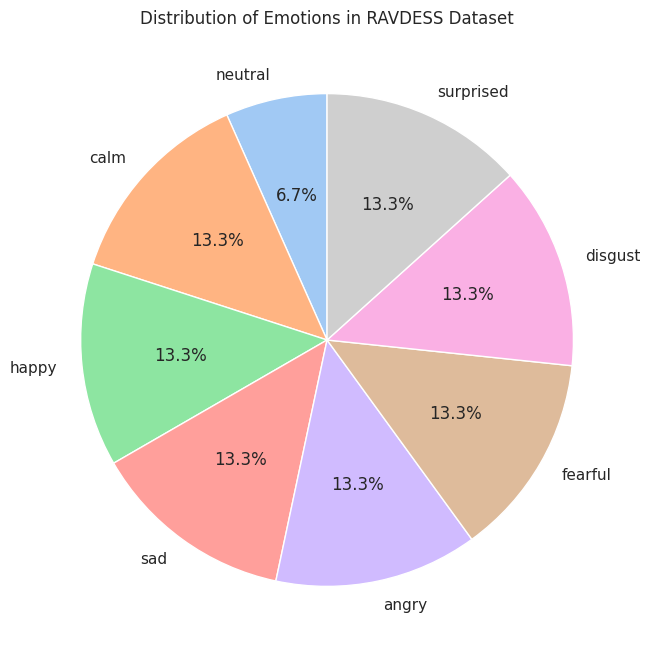

In [ ]:
label_counts = pd.Series(Y).value_counts().sort_index()

plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=[labels[i] for i in label_counts.index], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel')[0:len(labels)])
plt.title('Distribution of Emotions in RAVDESS Dataset')
plt.show()

# Training model

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

In [ ]:
X_train.shape

(1152, 26)

In [ ]:
Y_train[0]

np.int64(7)

In [ ]:
print("Bắt đầu vào huấn luyện...")
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('pca', PCA(n_components=0.95)),
                     ('svm', SVC(kernel='rbf', class_weight='balanced'))])
param_grid = {'svm__C': [0.01, 0.1, 1, 10, 100],
              'svm__gamma': [1e-4, 1e-3, 1e-2, 1e-1, 1]}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = GridSearchCV(pipeline, param_grid, scoring='f1_macro', cv=cv)
model.fit(X_train, Y_train)
print("Hoàn tất huấn luyện.")

Bắt đầu vào huấn luyện...
Hoàn tất huấn luyện.


In [ ]:
print(f"Traning Score: {model.score(X_train, Y_train)}")

Traning Score: 1.0


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred

array([6, 8, 8, 4, 1, 6, 5, 5, 8, 8, 2, 1, 7, 7, 3, 4, 1, 1, 4, 1, 2, 5,
       3, 6, 5, 3, 8, 1, 1, 1, 2, 2, 4, 4, 8, 3, 6, 2, 2, 5, 7, 8, 3, 5,
       7, 5, 8, 8, 2, 6, 3, 2, 6, 5, 5, 6, 1, 2, 6, 7, 4, 8, 2, 1, 5, 2,
       2, 4, 5, 5, 2, 4, 1, 5, 6, 8, 5, 2, 6, 3, 1, 6, 6, 8, 3, 6, 8, 4,
       4, 7, 3, 4, 6, 7, 4, 7, 2, 7, 1, 2, 2, 3, 7, 2, 5, 3, 5, 6, 1, 8,
       1, 8, 1, 3, 4, 7, 3, 2, 5, 4, 2, 6, 5, 2, 4, 6, 3, 2, 4, 5, 8, 4,
       7, 8, 4, 5, 2, 3, 2, 6, 6, 8, 2, 5, 8, 6, 2, 4, 2, 2, 6, 6, 8, 6,
       2, 3, 8, 4, 3, 8, 6, 8, 2, 2, 7, 2, 7, 1, 6, 6, 2, 4, 7, 2, 7, 6,
       3, 5, 1, 8, 8, 8, 2, 3, 5, 6, 3, 5, 7, 5, 5, 2, 6, 4, 2, 6, 4, 6,
       6, 8, 1, 6, 3, 4, 6, 8, 6, 4, 8, 4, 3, 2, 3, 4, 5, 5, 8, 4, 8, 2,
       7, 3, 2, 5, 5, 3, 5, 7, 8, 4, 7, 2, 8, 3, 6, 7, 1, 8, 7, 7, 3, 4,
       5, 8, 6, 4, 6, 8, 6, 2, 6, 5, 4, 7, 7, 8, 7, 5, 7, 2, 5, 8, 1, 4,
       6, 2, 6, 3, 7, 7, 3, 2, 6, 1, 6, 8, 2, 3, 7, 8, 1, 6, 3, 7, 7, 2,
       3, 2])

In [ ]:
Y_test

array([3, 8, 8, 7, 3, 6, 5, 5, 8, 1, 2, 1, 7, 5, 3, 4, 1, 2, 4, 1, 2, 5,
       3, 8, 5, 3, 3, 8, 1, 1, 2, 2, 4, 4, 8, 6, 6, 4, 2, 5, 4, 8, 3, 5,
       5, 5, 3, 8, 2, 6, 8, 4, 6, 5, 5, 3, 1, 2, 8, 8, 4, 8, 2, 1, 5, 3,
       8, 4, 5, 5, 2, 4, 2, 5, 3, 5, 5, 6, 6, 6, 4, 7, 6, 8, 3, 6, 8, 4,
       4, 7, 3, 6, 6, 7, 4, 7, 2, 7, 4, 2, 2, 5, 7, 2, 8, 3, 7, 6, 2, 8,
       1, 8, 1, 3, 2, 7, 3, 2, 5, 4, 7, 6, 5, 2, 6, 6, 3, 2, 6, 5, 8, 8,
       7, 8, 4, 5, 2, 3, 2, 6, 4, 7, 2, 5, 7, 6, 7, 4, 2, 4, 6, 6, 8, 6,
       1, 3, 8, 7, 3, 3, 6, 8, 2, 2, 7, 2, 7, 3, 6, 6, 6, 4, 7, 2, 5, 3,
       3, 5, 8, 5, 8, 8, 4, 3, 6, 5, 6, 5, 7, 5, 5, 2, 4, 7, 2, 6, 4, 8,
       5, 8, 4, 6, 3, 7, 6, 1, 6, 4, 8, 4, 3, 2, 3, 4, 5, 5, 8, 4, 3, 2,
       7, 3, 7, 5, 5, 3, 5, 5, 8, 4, 8, 2, 8, 3, 7, 7, 1, 8, 7, 7, 3, 4,
       1, 8, 6, 2, 6, 1, 6, 2, 6, 5, 4, 7, 8, 7, 7, 5, 7, 2, 8, 8, 4, 4,
       6, 4, 6, 3, 7, 7, 3, 2, 4, 1, 6, 1, 2, 3, 7, 3, 1, 4, 3, 7, 7, 1,
       7, 4])

In [ ]:
classification_report(Y_test, y_pred, target_names=labels.values())

'              precision    recall  f1-score   support\n\n     neutral       0.52      0.63      0.57        19\n        calm       0.69      0.87      0.77        38\n       happy       0.81      0.68      0.74        38\n         sad       0.70      0.61      0.65        38\n       angry       0.86      0.77      0.81        39\n     fearful       0.67      0.77      0.71        39\n     disgust       0.75      0.63      0.69        38\n   surprised       0.65      0.67      0.66        39\n\n    accuracy                           0.71       288\n   macro avg       0.71      0.70      0.70       288\nweighted avg       0.72      0.71      0.71       288\n'

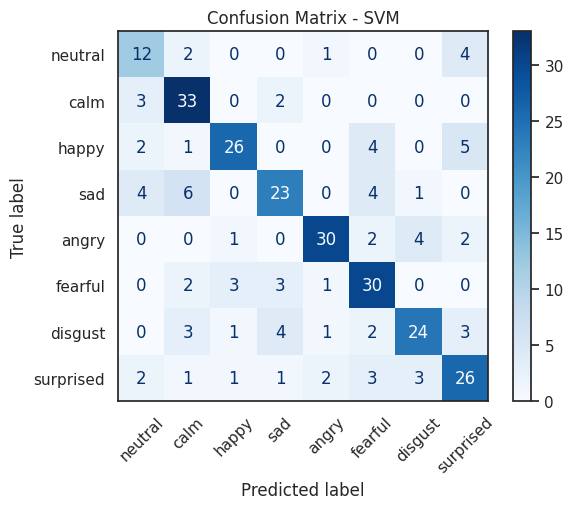

In [ ]:
cm = confusion_matrix(Y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels.values())
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - SVM")
plt.show()

In [ ]:
rsme = np.sqrt(np.mean((Y_test - y_pred)**2))
print(f"RMSE: {rsme}")
r2 = 1 - (np.sum((Y_test - y_pred)**2) / np.sum((Y_test - np.mean(Y_test))**2))
print(f"R2: {r2}")

RMSE: 1.8027756377319946
R2: 0.31176470588235294


In [ ]:
!pip install joblib

In [ ]:
import joblib

In [ ]:
joblib.dump(model, 'model.joblib')

['model.joblib']